# financialmodellingprep


In [6]:

import requests
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from ipywidgets import HTML
import inspect

apikey=os.environ['FINANCIALMODELLINGPREP_APIKEY']
dumpdir="C:\\Users\\andreas\\iCloudDrive\\ressources\\stockdata"

# Definitions
FinancialModellingPrep offers API endpoints that give use balance sheets and income statements for many companies. Since we mostly care about annual statements, we write all our api calls to a dump dir to be able to access them later. For all the SP500, this is about 50 MB/Year

In [54]:
def apicall(endpoint,fname,param="?"):    
    try:
        fullpath=dumpdir+'\\'+fname        
        with open(fullpath, 'r') as f:           
            return json.load(f)            
    except:
        url="https://financialmodelingprep.com/api/v3/"+endpoint+param+"&apikey="+apikey        
        response=requests.get(url)        
        data=response.json()
        if (response.status_code==200):
            with open(dumpdir+'\\'+fname, 'w') as f:
                json.dump(data, f)
        return data

def balancesheet(company):
    endpoint="balance-sheet-statement/"+company
    fname="balance-sheet-"+company+".json"
    return apicall(endpoint,fname)

def cashflow(company):
    endpoint="cash-flow-statement/"+company
    fname="cash-flow-"+company+".json"
    return apicall(endpoint,fname)

def incomestatement(company):
    endpoint="income-statement/"+company
    fname="income-"+company+".json"
    return apicall(endpoint,fname)


def historicalprice(company,year):
    endpoint="historical-price-full/"+company
    param="?from="+year+"-01-01"+"&to="+year+"-12-31"    
    fname=company+"-"+year
    data=apicall(endpoint,fname,param)
    frame=pd.DataFrame(data['historical'])
    frame['ticker']=company
    return frame

def sp500():
    f = open(dumpdir+"\\sp500_now.json")
    sp500=json.load(f)
    symbols=[ x['symbol'] for x in sp500 ]
    return symbols

digitsAfterComma=1
def formatCurrency(x):
    try:
        if (abs(x / 1000000000)>1):
            num=x/1000000000
            return "{:.2f}".format(num)+" Bio."
        if (abs(x/1000000)>1):
            num=x/1000000
            return "{:.2f}".format(num)+" Mio."
        return "{:.2f}".format(x);
    except TypeError:
        return x;

leftCol=[{'colName':'cashAndCashEquivalents','format':formatCurrency},
         {'colName':'shortTermInvestments','format':formatCurrency},
         {'colName':'netReceivables','format':formatCurrency},
         {'colName':'inventory','format':formatCurrency},
         {'colName':'otherCurrentAssets','format':formatCurrency},
         {'colName':'totalCurrentAssets','format':formatCurrency,'labelClass':'balance-emph','valueClass':'balance-value-emph'},
         {'colName':'propertyPlantEquipmentNet','format':formatCurrency},
         {'colName':'goodwillAndIntangibleAssets','format':formatCurrency},
         {'colName':'longTermInvestments','format':formatCurrency},
         {'colName':'totalNonCurrentAssets','format':formatCurrency},
        {'colName':'totalAssets','format':formatCurrency,'labelClass':'balance-emph','valueClass':'balance-value-emph'},]
rightCol=[
    {'colName':'accountPayables','format':formatCurrency},
    {'colName':'shortTermDebt','format':formatCurrency},
    {'colName':'taxPayables','format':formatCurrency},
    {'colName':'deferredRevenue','format':formatCurrency},
    {'colName':'otherCurrentLiabilities','format':formatCurrency},
    {'colName':'totalCurrentLiabilities','format':formatCurrency,'labelClass':'balance-emph','valueClass':'balance-value-emph'},
    {'colName':'longTermDebt','format':formatCurrency},
    {'colName':'totalLiabilities','format':formatCurrency,'labelClass':'balance-emph','valueClass':'balance-value-emph'},
    {'colName':'totalEquity','format':formatCurrency,'labelClass':'balance-emph','valueClass':'balance-value-emph'}]

incomeCol=[    
    {'colName':'revenue','format':formatCurrency},
    {'colName':'costOfRevenue','format':formatCurrency},
    {'colName':'grossProfit','format':formatCurrency},
    {'colName':'operatingExpenses','format':formatCurrency},
    {'colName':'operatingIncome','format':formatCurrency},
    {'colName':'incomeTaxExpense','format':formatCurrency},
    {'colName':'netIncome','format':formatCurrency},
]
def bold(s):
    return "<b>"+s+'</b>'
css_str = '<style>.balance-label{color:#00;} .balance-value{color:#00;text-align: right } .balance-value-emph { text-decoration-line: underline} .balance-emph{font-weight: bold}</style>'

def emitElement(element,data):
    if bool(element)==False:
        return "<td></td><td></td>"
    try:
        rightLabel=element['colName']
        rightVal=data[element['colName']]
    except:
        rightLabel=""
        rightEl=""
        rightVal=""
    formater=element['format']
    if (inspect.isfunction(formater)):            
        rightVal=formater(rightVal)
    if ('labelClass' in element):
        labelClass=element['labelClass']+' balance-label'
    else:
        labelClass='balance-label'
        
    if ('valueClass' in element):
        valueClass=element['valueClass']+' balance-value'
    else:
        valueClass='balance-value'   
    s='<td class="'+labelClass+'" style="padding-right: 10px">'+rightLabel+'</td>'
    s=s+'<td class="'+valueClass+'" style="padding-right: 30px">'+str(rightVal)+"</td>"
    return s
    
def displayBalance(data):    
    l=leftCol.copy() 
    r=rightCol.copy()
    title="Balance sheet "+data['symbol']+" "+data['calendarYear']
    s=css_str+'<table style="border-spacing: 30px"><tr><th colspan=4>'+title+'</th></tr>'
    while len(r)>0 or len(l)>0:        
        try:
            leftEl=l.pop(0)            
        except:
            leftEl={}
            leftVal=""
        try:
            rightEl=r.pop(0)            
            rightVal=data[rightEl['colName']]
        except:
            rightEl={}
            rightVal=""
        s=s+"<tr>"+emitElement(leftEl,data)+emitElement(rightEl,data)+"</tr>\n"
    s=s+"</table>"
    return HTML(s)

def displayIncome(data):
    l=incomeCol.copy() 
    title="Income "+data['symbol']+" "+data['calendarYear']
    s=css_str+'<table style="border-spacing: 30px"><tr><th colspan=2>'+title+'</th></tr>'
    while len(l)>0:        
        try:
            leftEl=l.pop(0)            
        except:
            leftEl={}
            leftVal=""        
        s=s+"<tr>"+emitElement(leftEl,data)+"</tr>\n"
    s=s+"</table>"
    return HTML(s)


In [14]:
data=historicalprice("AAPL","2022")

In [39]:
displayBalance(balancesheet('AAPL')[9])

HTML(value='<style>.balance-label{color:#00;} .balance-value{color:#00;text-align: right } .balance-value-emph…

In [20]:
incomestatement('MSFT')[0]

{'date': '2022-06-30',
 'symbol': 'MSFT',
 'reportedCurrency': 'USD',
 'cik': '0000789019',
 'fillingDate': '2022-07-28',
 'acceptedDate': '2022-07-28 16:06:19',
 'calendarYear': '2022',
 'period': 'FY',
 'revenue': 198270000000,
 'costOfRevenue': 62650000000,
 'grossProfit': 135620000000,
 'grossProfitRatio': 0.6840167448,
 'researchAndDevelopmentExpenses': 24512000000,
 'generalAndAdministrativeExpenses': 5900000000,
 'sellingAndMarketingExpenses': 21825000000,
 'sellingGeneralAndAdministrativeExpenses': 27725000000,
 'otherExpenses': 0,
 'operatingExpenses': 52237000000,
 'costAndExpenses': 114887000000,
 'interestIncome': 2094000000,
 'interestExpense': 2063000000,
 'depreciationAndAmortization': 16856000000,
 'ebitda': 100239000000,
 'ebitdaratio': 0.5055681646,
 'operatingIncome': 83383000000,
 'operatingIncomeRatio': 0.4205527816,
 'totalOtherIncomeExpensesNet': 333000000,
 'incomeBeforeTax': 83716000000,
 'incomeBeforeTaxRatio': 0.4222323095,
 'incomeTaxExpense': 10978000000,
 

In [31]:
displayIncome(incomestatement('AMZN')[0])

HTML(value='<style>.balance-label{color:#00;} .balance-value{color:#00;text-align: right } .balance-value-emph…

In [55]:
balance={}
cash={}
income={}
for i in sp500():
    balance[i]=balancesheet(i)
    income[i]=incomestatement(i)
    cash[i]=cashflow(i)

In [ ]:
# Pandas beladen

In [56]:
balancefiles=list(filter(lambda x: x.startswith('balance'),os.listdir(dumpdir)))

In [57]:
df=pd.DataFrame()
for f in balancefiles:
   nf=pd.read_json(dumpdir+"/"+f)
   df=pd.concat([df,nf])

In [32]:
for i in sp500():
    historicalprice(i,"2021")

KeyError: 'historical'

In [351]:
len(symbols)

NameError: name 'symbols' is not defined

# Einschränken auf 2022

In [58]:
filtered=df.loc[(df.symbol=='JPM')]

In [59]:
filtered

ValueError: Invalid format specifier

ValueError: Invalid format specifier

In [43]:
filtered=df.loc[(df.calendarYear==2022)]


# Höchstverschuldete Unternehmen
Wenig überraschend sind alles Banken.

In [40]:
filtered.loc[:,'totalDebt'].max()/1000000

466727.0

In [37]:
filtered.sort_values(by='totalDebt',ascending=False)

,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,...,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt,link,finalLink
0,2022-12-31,JPM,USD,19617,2023-02-21,2023-02-21 16:13:55,2022,FY,5.672340e+11,205857000000,...,2.923320e+11,2.923320e+11,3.665743e+12,0,3.665743e+12,1.219938e+12,4.667270e+11,-1.005070e+11,https://www.sec.gov/Archives/edgar/data/19617/...,https://www.sec.gov/Archives/edgar/data/19617/...
0,2022-12-31,GS,USD,886982,2023-02-24,2023-02-23 19:58:16,2022,FY,2.418250e+11,13180000000,...,1.171890e+11,1.171890e+11,1.441799e+12,0,1.441799e+12,5.626290e+11,3.241990e+11,8.237400e+10,https://www.sec.gov/Archives/edgar/data/886982...,https://www.sec.gov/Archives/edgar/data/886982...
0,2022-12-31,C,USD,831001,2023-02-27,2023-02-24 21:45:33,2022,FY,3.420250e+11,238746000000,...,2.011890e+11,2.011890e+11,2.416027e+12,0,2.416027e+12,9.549740e+11,3.187020e+11,-2.332300e+10,https://www.sec.gov/Archives/edgar/data/831001...,https://www.sec.gov/Archives/edgar/data/831001...
0,2022-12-31,BAC,USD,70858,2023-02-22,2023-02-22 16:33:50,2022,FY,2.374620e+11,220788000000,...,2.731970e+11,2.731970e+11,3.050706e+12,0,3.050706e+12,1.379159e+12,3.029140e+11,6.545200e+10,https://www.sec.gov/Archives/edgar/data/70858/...,https://www.sec.gov/Archives/edgar/data/70858/...
0,2022-12-31,MS,USD,895421,2023-02-24,2023-02-24 16:05:43,2022,FY,9.274700e+10,20509000000,...,1.001410e+11,1.001410e+11,1.180231e+12,0,1.180231e+12,8.096200e+10,2.462160e+11,1.534690e+11,https://www.sec.gov/Archives/edgar/data/895421...,https://www.sec.gov/Archives/edgar/data/895421...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2022-12-31,PAYC,USD,1590955,2023-02-16,2023-02-16 16:09:38,2022,FY,4.007300e+08,0,...,1.182607e+09,1.182607e+09,3.902513e+09,0,3.902513e+09,0.000000e+00,2.900000e+07,-3.717300e+08,https://www.sec.gov/Archives/edgar/data/159095...,https://www.sec.gov/Archives/edgar/data/159095...
0,2022-12-31,MPWR,USD,1280452,2023-02-24,2023-02-24 16:16:51,2022,FY,2.886070e+08,449266000,...,1.668602e+09,1.668602e+09,2.058885e+09,0,2.058885e+09,4.492660e+08,0.000000e+00,-2.886070e+08,https://www.sec.gov/Archives/edgar/data/128045...,https://www.sec.gov/Archives/edgar/data/128045...
0,2022-12-31,NVR,USD,906163,2023-02-15,2023-02-15 15:38:46,2022,FY,2.503424e+09,0,...,3.506849e+09,3.506849e+09,5.660973e+09,0,5.660973e+09,0.000000e+00,0.000000e+00,-2.503424e+09,https://www.sec.gov/Archives/edgar/data/906163...,https://www.sec.gov/Archives/edgar/data/906163...
0,2022-12-31,MNST,USD,865752,2023-03-01,2023-03-01 13:56:13,2022,FY,1.307141e+09,1362314000,...,7.025041e+09,7.025041e+09,8.293105e+09,0,8.293105e+09,1.423757e+09,0.000000e+00,-1.307141e+09,https://www.sec.gov/Archives/edgar/data/865752...,https://www.sec.gov/Archives/edgar/data/865752...


In [38]:
x=filtered.totalEquity
y=filtered.totalDebt


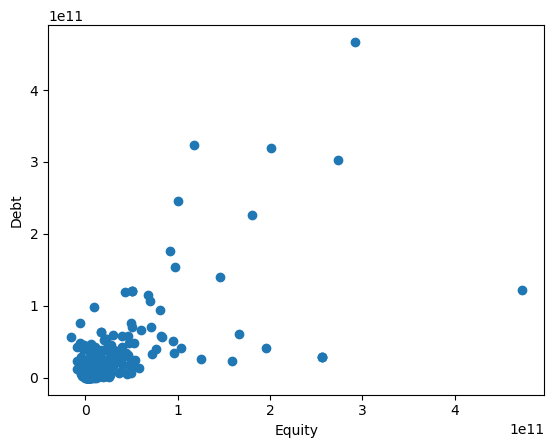

In [57]:
plt.scatter(x,y)
plt.xlabel('Equity')
plt.ylabel('Debt')
# Show the plot
plt.show()